[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Exploring Different Vision Tasks with Florence-2

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/florence-2/)
[![arXiv](https://img.shields.io/badge/arXiv-2311.06242-b31b1b.svg)](https://arxiv.org/abs/2311.06242)

## Setup

### Configure your API keys

To run Florence-2, you need to provide your HuggingFace Token. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store HuggingFace Access Token under the name `HF_TOKEN`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
# !nvidia-smi

### Install extra dependencies

 Let's download the model checkpoint and configure it so that you can fine-tune it later on.

In [2]:
!pip install transformers flash_attn timm einops supervision==0.22.0rc1  --quiet


[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


### Download example data

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /opt/app-root/src/AI-Engineering.academy/Finetuning/VLM


**NONE:** Let's download few example images. Feel free to use your images or videos.

In [4]:
!mkdir -p {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/inference/license_plate_1.jpg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/handwritten-text.jpg -P {HOME}/data

## Load pre-trained Florence-2 model

Load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor` classes from the transformers library. Note that you need to pass `trust_remote_code` as `True` since this model is not a standard transformers model.

In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoProcessor

# model.push_to_hub("vllm-alan/Florence-2-FT-DocVQA")
# processor.push_to_hub("vllm-alan/Florence-2-FT-DocVQA")

# CHECKPOINT = "microsoft/Florence-2-base-ft"
CHECKPOINT = "vllm-alan/Florence-2-FT-DocVQA"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

## Run inference with pre-trained Florence-2 model

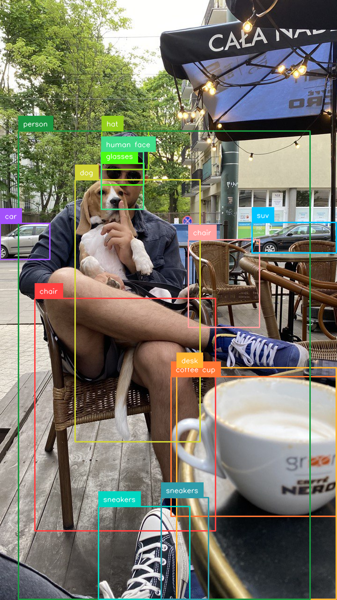

In [6]:
# @title Example object detection (`<OB>`) inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
text = "<OD>"
task = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=image.size)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

**NOTE:** Note that out of the box Florence-2 detects far more classes than the typical model pretreated on the COCO dataset.

In [7]:
 # @title Wrap inference code into utility function

def run_inference(image: Image, task: str, text: str = ""):
    prompt = task + text
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    return processor.post_process_generation(generated_text, task=task, image_size=image.size)

**NOTE:** Florence-2 offers 3 types of imag caption tasks - `<CAPTION>`, `<DETAILED_CAPTION>`, `<MORE_DETAILED_CAPTION>` differing in level of detail. Let's compare the results obtained.

In [8]:
# @title Example `<CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<CAPTION>"

response = run_inference(image=image, task=task)
response

{'<CAPTION>': 'A man sitting in a chair holding a dog.'}

In [9]:
# @title Example `<DETAILED_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
response

{'<DETAILED_CAPTION>': 'In this picture we can see a man sitting on a chair and holding a dog in his hand and in front of him we can find a cup and a mobile on the table, in the background there are some chairs, buildings, lights and trees.'}

In [10]:
# @title Example `<MORE_DETAILED_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<MORE_DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
response

{'<MORE_DETAILED_CAPTION>': 'A man is sitting outside on a sunny day. He is wearing a black hat, sunglasses, and a blue shirt. The man is holding a white dog in his lap. There is a black table in front of the man with a white cup on it. There are brown chairs around the table. Part of a building can be seen behind the man. Tall green trees are standing near the building.'}

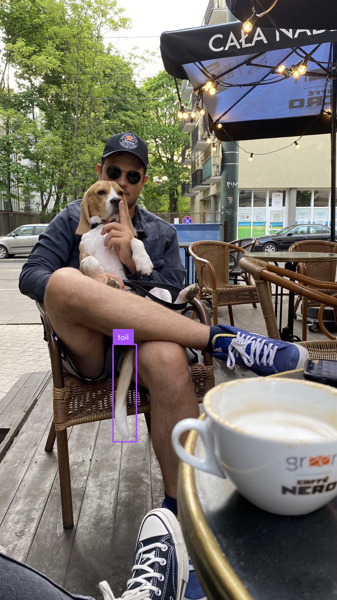

In [11]:
# @title Example `<CAPTION_TO_PHRASE_GROUNDING>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<CAPTION_TO_PHRASE_GROUNDING>"
text = "tail"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In this picture we can see a man sitting on a chair and holding a dog in his hand and in front of him we can find a cup and a mobile on the table, in the background there are some chairs, buildings, lights and trees.


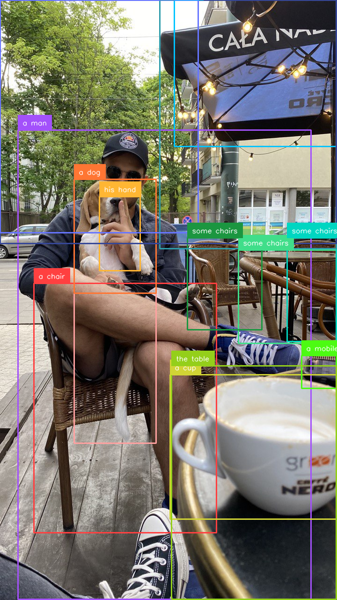

In [12]:
# @title Example `<DETAILED_CAPTION>` + `<CAPTION_TO_PHRASE_GROUNDING>` combo inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<DETAILED_CAPTION>"

response = run_inference(image=image, task=task)
text = response[task]

task = "<CAPTION_TO_PHRASE_GROUNDING>"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))

print(text)
image

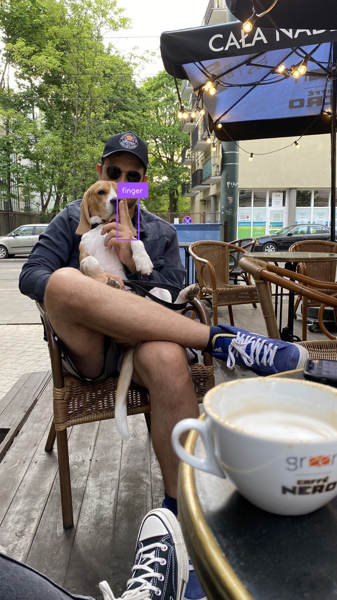

In [13]:
# @title Example `<OPEN_VOCABULARY_DETECTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<OPEN_VOCABULARY_DETECTION>"
text = "finger"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

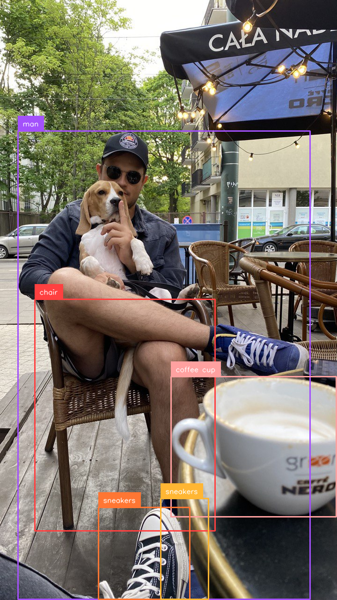

In [14]:
# @title Example `<DENSE_REGION_CAPTION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<DENSE_REGION_CAPTION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

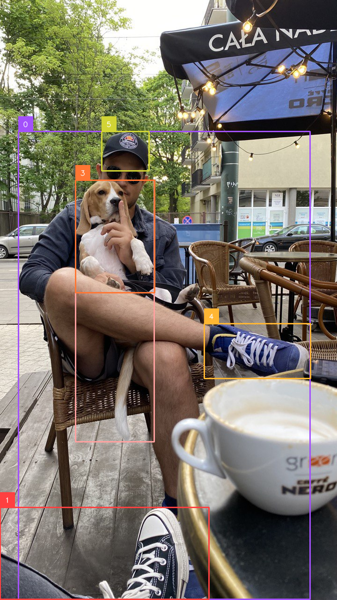

In [15]:
# @title Example `<REGION_PROPOSAL>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<REGION_PROPOSAL>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

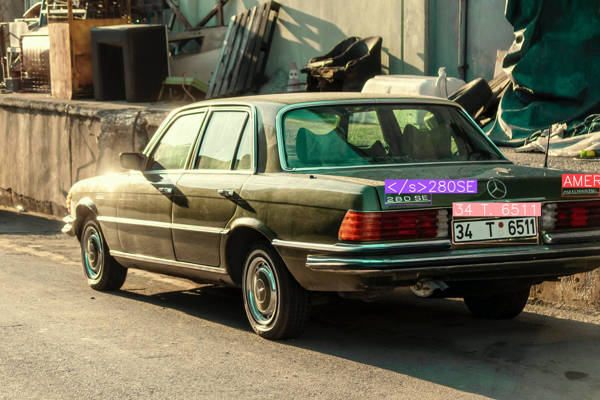

In [16]:
# @title Example `<OCR_WITH_REGION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/license_plate_1.jpg")
task = "<OCR_WITH_REGION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX,
    text_scale=3,
    text_thickness=4
)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

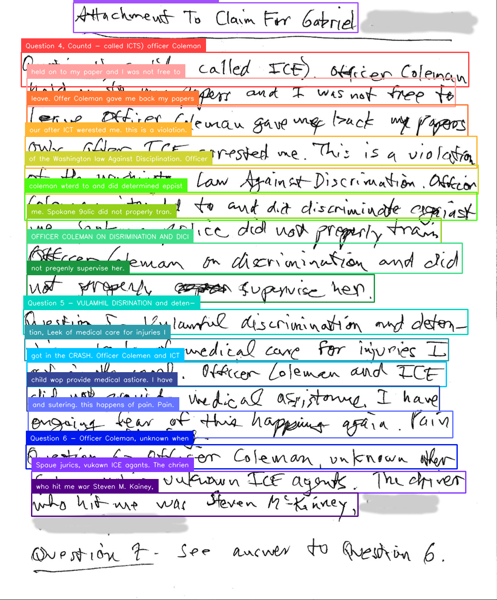

In [17]:
import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/handwritten-text.jpg")
task = "<OCR_WITH_REGION>"

response = run_inference(image=image, task=task)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [18]:
# @title Example `<OCR>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/handwritten-text.jpg")
task = "<OCR>"

response = run_inference(image=image, task=task)
response[task]

'Attachment To CLAIM FOR GATRIELQuestion 4, Countd - called ICTS) officer Colemanheld on to my paper and I was not free toLeve. Offer Coleman gave me back my papersour after ICT werested me. This is a violationof the Washington law Against DISCRIMINATION. Officercoleman watered to and did disCRIMUNDE eggiastme. Spokane 9olicid did not properly tran.OFFICER COLEMAN ON DISCRIINATION AND DICKnot prigeney Supervice her.Question 5 - VULAMHIL DISCININATION and deten-tian, Leek of medical care for injuries I got in the CRASH. Officer Colemen and ICTchild wop provide medicalastone. I haveengry fear of this happens of pain. Painand sutering.Question 6 - Officer Coleman, unknown whenSpaue jurics, vukawn ICE agants. The chrienwho hit me warSteven M. Kinney,Question 7 - Seecurve to Question 6'

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


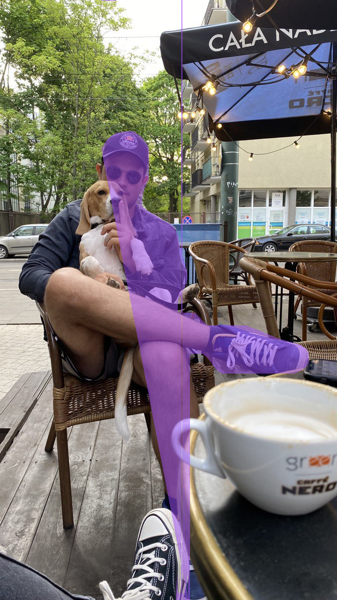

In [19]:
# @title Example `<REFERRING_EXPRESSION_SEGMENTATION>` inference

import supervision as sv
from PIL import Image

image = Image.open(f"{HOME}/data/dog-3.jpeg")
task = "<REFERRING_EXPRESSION_SEGMENTATION>"
text = "man"

response = run_inference(image=image, task=task, text=text)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = mask_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

# Congratulations

⭐️ If you enjoyed this notebook, [**star the Roboflow Notebooks repo**](https://https://github.com/roboflow/notebooks) (and [**supervision**](https://github.com/roboflow/supervision) while you're at it) and let us know what tutorials you'd like to see us do next. ⭐️